In [1]:
# Imports
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sts
import seaborn as sns
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols

from lib.utility_functions import *
from lib.exp4 import *

# Config
sns.set_style('white')
sns.set_context('talk')

pd.set_option('display.max_columns', 40)

% matplotlib inline

/Users/gianni/anaconda/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
tidy = pd.read_csv('./tidy_data.csv', index_col=0)

In [77]:

original_condition = tidy['Condition'].values
oritinal_real = tidy['Is Real'].values

is_trained = tidy['Condition'] == 'Trained'
is_real = tidy['Is Real']

# Difference between *condition* split by *is real*
original_true_dif = tidy.loc[is_trained & is_real, 'Total Errors'].mean() - tidy.loc[~is_trained & is_real, 'Total Errors'].mean()
original_false_dif = tidy.loc[is_trained & ~is_real, 'Total Errors'].mean() - tidy.loc[~is_trained & ~is_real, 'Total Errors'].mean()

# Difference between *is real* split by *condition*
original_trained_dif = tidy.loc[is_trained & is_real, 'Total Errors'].mean() - tidy.loc[is_trained & ~is_real, 'Total Errors'].mean()
original_naive_dif = tidy.loc[~is_trained & is_real, 'Total Errors'].mean() - tidy.loc[~is_trained & ~is_real, 'Total Errors'].mean()

print(original_true_dif, original_false_dif)
print(original_trained_dif, original_naive_dif)

-0.5307017543859649 -0.5394736842105265
-2.104166666666667 -2.1129385964912286


In [43]:
n_resamples = 100000

resampled_true = []
resampled_false = []

for i in range(n_resamples):
    tidy['Condition_R'] = tidy['Condition'].sample(frac=1, replace=False).values
    is_trained = tidy['Condition_R'] == 'Trained'
    is_real = tidy['Is Real']
    
    true_dif = tidy.loc[is_trained & is_real, 'Total Errors'].mean() - tidy.loc[~is_trained & is_real, 'Total Errors'].mean()
    false_dif = tidy.loc[is_trained & ~is_real, 'Total Errors'].mean() - tidy.loc[~is_trained & ~is_real, 'Total Errors'].mean()
    
    resampled_true.append(true_dif)
    resampled_false.append(false_dif)

/Users/gianni/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


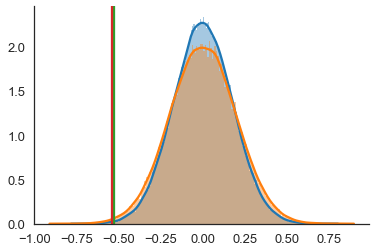

In [44]:
# sorted_resampled_true = np.sort(resampled_true)
# plt.plot(sorted_resampled_true, linestyle='none', marker='o')
sns.distplot(resampled_true, bins=200, norm_hist=True)
sns.distplot(resampled_false, bins=200, norm_hist=True)

plt.plot([original_true_dif, original_true_dif], [0, 2.5])
plt.plot([original_false_dif, original_false_dif], [0, 2.5])

sns.despine()

In [45]:
resampled_true = np.stack(resampled_true)
true_loc = (resampled_true >= np.abs(original_true_dif))
true_loc |= (resampled_true <= -np.abs(original_true_dif))

len(resampled_true[true_loc]) / len(resampled_true)

0.00252

In [79]:
resampled_trained = []
resampled_naive = []

g = tidy.groupby('Subject ID', sort=False)

for i in range(n_resamples):
    tidy['Is Real_R'] = pd.melt(
        pd.DataFrame(g.apply(lambda x: x[['Is Real', 'Subject ID']].sample(frac=1, replace=False))),
        id_vars=['Subject ID'], value_vars=['Is Real'], value_name='Is Real'
    )['Is Real'].values

    is_trained = tidy['Condition'] == 'Trained'
    is_real = tidy['Is Real_R']
    
    trained_dif = tidy.loc[is_trained & is_real, 'Total Errors'].mean() - tidy.loc[is_trained & ~is_real, 'Total Errors'].mean()
    naive_dif = tidy.loc[~is_trained & is_real, 'Total Errors'].mean() - tidy.loc[~is_trained & ~is_real, 'Total Errors'].mean()

    resampled_trained.append(trained_dif)
    resampled_naive.append(naive_dif)

/Users/gianni/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


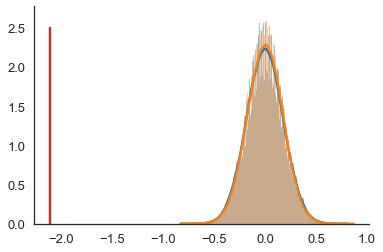

In [80]:
sns.distplot(resampled_trained, bins=200, norm_hist=True)
sns.distplot(resampled_naive, bins=200, norm_hist=True)

plt.plot([original_trained_dif, original_trained_dif], [0, 2.5])
plt.plot([original_naive_dif, original_naive_dif], [0, 2.5])

sns.despine()

In [81]:
resampled_trained = np.stack(resampled_trained)
true_loc = (resampled_trained >= np.abs(original_trained_dif))
true_loc |= (resampled_trained <= -np.abs(original_trained_dif))

len(resampled_trained[true_loc]) / len(resampled_trained)

0.0